In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

N = 10000
p = [.2,.25,.25,.3]
priors = np.array([.2,.25,.25,.3])

# ARBITRARILY CHOSEN
# Create the mus and sigmas
# equally spaced means along a line
mu =[[0, 0],[4, 0],[8, 0],[12, 0]]
# scaled versions of the identity matrix with overlap
sigma =[[[2, 0],[0, 2]],
        [[4, 0],[0, 4]],
        [[6, 0],[0, 6]],
        [[8, 0],[0, 8]]]

n = mu.shape[1] # 
C = len(priors) # Classes
L = np.array(range(C)) # labels

u = np.random.rand(N)

# set thresholds: 0 -> 0.65 -> 1
thresholds = np.cumsum(priors)
print(thresholds)
thresholds = np.insert(thresholds,0,0)
print(thresholds)

# create empty matrix for samples of size 10,000 x 3
X = np.zeros([N,n])

# create empty labels array of length 10,000
labels = np.zeros(N)

# Plot for original data and their true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = '....'
marker_colors = 'rbgy' 

for i in range(C):

    # Find indices of u that meet each prior
    indices = np.argwhere((thresholds[i] <= u) & (u <= thresholds[i+1]))[:, 0]
    print(indices)

    # Get the number of indices in each component - should be ~ 6500 and 3500
    Nl = len(indices)
    
    # set label vector based on above - will be vector of class labels [0 0 1 0 1 .. to 9999] in this case
    # for more classes, this can be [1 2 2 0 1 3 1 3 0 ...]
    labels[indices] = i * np.ones(Nl)
    
    # for each valid index, fill the 
    X[indices, :] = multivariate_normal.rvs(mu[i], sigma[i], Nl)
    plt.plot(X[labels==i, 0], X[labels==i, 1], marker_shapes[i-1] + marker_colors[i-1], label="True Class {}".format(i))

#-------------------------------------------------

N_samples =[0, 0, 0, 0]

# Assign the number of samples
for i in range(0, N):
    randnum = random.random()
    if randnum < p[0] :
        N_samples[0] = N_samples[0] + 1
    elif randnum < p[0] + p[1] :
        N_samples[1] = N_samples[1] + 1
    elif randnum < p[0] + p[1] + p[2] :
        N_samples[2] = N_samples[2] + 1
    else :
        N_samples[3] = N_samples[3] + 1

# ARBITRARILY CHOSEN
# Create the mus and sigmas
# equally spaced means along a line
mu =[[0, 0],[4, 0],[8, 0],[12, 0]]
# scaled versions of the identity matrix with overlap
sigma =[[[2, 0],[0, 2]],
        [[4, 0],[0, 4]],
        [[6, 0],[0, 6]],
        [[8, 0],[0, 8]]]
r =[]
loss_matrix =[[ 0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]
#cr e ate d atapoints in eac h distrib ution
for i in range(0, 4):
    r.append (np.random. multivariate_normal (mu[i], sigma [i], N_samples [i ]))
# plotdistrib ution s
plt.figure(0)
plt.scatter(r[0][:, 0], r[0][:, 1],label= ' Class0 ')
plt.scatter(r[1][:, 0], r[1][:, 1], c= 'r',label= ' Class1 ')
plt.scatter(r[2][:, 0], r[2][:, 1], c= 'g',label= ' Class2 ')
plt.scatter(r[3][:, 0], r[3][:, 1], c= 'y',label= ' Class3 ')
plt.legend()
plt.title('True ClassLabels ')
plt.xlabel('X ')
plt.ylabel('y')
plt.show()


4
2
[0 1 2 3]
[0.2  0.45 0.7  1.  ]
[0.   0.2  0.45 0.7  1.  ]
[   2    4    5 ... 9988 9991 9996]


NameError: name 'mu' is not defined

<Figure size 720x720 with 0 Axes>

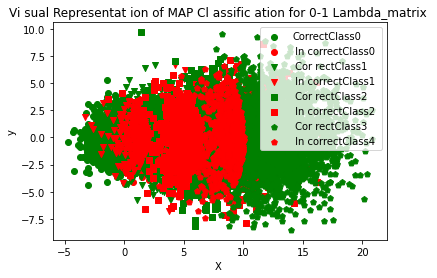

0.2591
[0.8971631205673759, 0.10283687943262411, 0.0, 0.0] 
 [0.11729141475211609, 0.7400241837968561, 0.1414752116082225, 0.0012091898428053204] 
 [0.004704037632301058, 0.1924735397883183, 0.5707565660525284, 0.23206585652685222] 
 [0.0, 0.020374081496325986, 0.19605878423513695, 0.7835671342685371]


In [10]:
# Lambda Matrix
lambda_matrix =[[ 0, 1, 1, 1],
                [1, 0, 1, 1],
                [1, 1, 0, 1],
                [1, 1, 1, 0]]

plt.figure(1)

# Risk Function returns expected risk for a given selection
def get_risk(i, x, lambda_mat):
    total= 0
    for j in range(0, 4):
        total = total + lambda_mat[i][j] * p[j] * multivariate_normal.pdf(x, mu[j], sigma[j])
    return total

# Function makes decisions for all datapoints in distribution given list of correct and incorrect decided points    
def get_MAP(gauss, lambda_matrix):
    correct=[]
    incorrect=[]
    for i in r[gauss] :
        choice = np.argmin([ get_risk(0,i, lambda_matrix), get_risk(1,i, lambda_matrix), get_risk(2,i,lambda_matrix), get_risk(3,i,lambda_matrix)])
        if choice == gauss :
            correct.append(i)
        else :
            incorrect.append(i)
        loss_matrix[gauss][choice] = loss_matrix[gauss][choice] + 1

    correct_xs=[]
    correct_ys=[]
    for i in correct:
        correct_xs.append(i[0 ])
        correct_ys.append(i[1 ])

    incorrect_xs=[]
    incorrect_ys=[]
    for i in incorrect:
        incorrect_xs.append(i[0 ])
        incorrect_ys.append(i[1 ])

    return [correct_xs, correct_ys],[incorrect_xs,incorrect_ys]


# Plot data for all distributions
correct,incorrect = get_MAP(0, lambda_matrix)

plt.scatter(correct[0], correct[1], c='g', marker='o',label='CorrectClass0')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'o',label= ' In correctClass0 ')
correct,incorrect= get_MAP(1, lambda_matrix)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 'v',label= ' Cor rectClass1 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'v',label= ' In correctClass1 ')
correct,incorrect= get_MAP(2, lambda_matrix)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 's',label= ' Cor rectClass2 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 's',label= ' In correctClass2 ')
correct,incorrect= get_MAP(3, lambda_matrix)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 'p',label= ' Cor rectClass3 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'p',label= ' In correctClass4 ')
plt.legend()
plt.title('Vi sual Representat ion of MAP Cl assific ation for 0-1 Lambda_matrix ')
plt.xlabel('X ')
plt.ylabel('y')
plt.show()

# Find total loss from loss matrix
total_loss= 0
for i in range(0, 4):
    for j in range(0, 4):
        if i != j :
            total_loss=total_loss+ loss_matrix [i][j]
print(total_loss/N)

# Find Confusion Matrix as ratios
for i in range(0, 4):
    loss_matrix [i] =[x / N_samples[i] for x in loss_matrix [i]]
print(loss_matrix[0],"\n",loss_matrix[1],"\n",loss_matrix[2],"\n",loss_matrix[3])


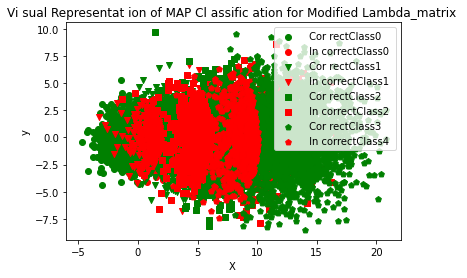

0.2578
[[0.8936170212765957, 0.10638297872340426, 0.0, 0.0], [0.11164852881902458, 0.7271261588069327, 0.1600161225312374, 0.0012091898428053204], [0.004704037632301058, 0.1736573892591141, 0.595452763622109, 0.2261858094864759], [0.0, 0.017702070808283232, 0.20240480961923848, 0.7798931195724783]]


In [11]:
# Pa rtB
#cr e ate new lambda_matrix
lambda_matrix_b =[[ 0, 1, 2, 3],[1, 0, 1, 2],[2, 1, 0, 1],[3, 2, 1, 0]]
loss_matrix =[[ 0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]
# plotnew d ata us ing get_MAP f u n ctionabov e
plt.figure(2)
correct,incorrect= get_MAP(0, lambda_matrix_b)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 'o',label= ' Cor rectClass0 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'o',label= ' In correctClass0 ')
correct,incorrect= get_MAP(1, lambda_matrix_b)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 'v',label= ' Cor rectClass1 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'v',label= ' In correctClass1 ')
correct,incorrect= get_MAP(2, lambda_matrix_b)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 's',label= ' Cor rectClass2 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 's',label= ' In correctClass2 ')
correct,incorrect= get_MAP(3, lambda_matrix_b)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 'p',label= ' Cor rectClass3 ')

plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'p',label= ' In correctClass4 ')
plt.legend()
plt.title('Vi sual Representat ion of MAP Cl assific ation for Modified Lambda_matrix ')
plt.xlabel('X ')
plt.ylabel('y')
plt.show()
# calculatetotallos s
total_loss= 0
for i in range(0, 4):
        for j in range(0, 4):
            if i != j :
                total_loss=total_loss+ loss_matrix [i][j]
print(total_loss/N)
# calculate con f u sio n matrix from lossmatr ix
for i in range(0, 4):
    loss_matrix [i] =[x / N_samples [i] for x in loss_matrix [i]]
print(loss_matrix)



